In [366]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from aquarel import load_theme


# Using the Aquarel library with some customization for the plots
theme = load_theme("boxy_dark")
theme.set_color(figure_background_color="#181818",
                plot_background_color="#242424")
theme.set_font(family="monospace", size=9)
theme.apply_transforms()
theme.apply()


df = pd.read_csv("Data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [368]:
# Adding the number of times a ticket was repeated to the dataframe
ticket_count = df["Ticket"].value_counts()
df["TicketCount"] = df["Ticket"].map(ticket_count)

# Adjusting the ticket price
df["AdjustedFare"] = round(df["Fare"] / df["TicketCount"], 4)

# Introducing a new and more meaningful feature
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# Extracting deck of residance for each passanger - N for NaN
df["Deck"] = df["Cabin"].str[0]
df["Deck"].fillna("N/A", inplace=True)

# Removing unnecessary feature
df.drop(columns=["Ticket", "SibSp", "Parch", "Fare", "TicketCount", "Cabin"], inplace=True, errors='ignore')

# Replacing missing age values with the average
df["Age"].fillna(int(df["Age"].median()), inplace=True)

# Defining a new feature - age group
age_bins = [0, 3, 12, 20, 60, 200]
age_labels = ["toddler", "child", "teen", "adult", "senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels)

# Replacing the missing embarked locations with the most frequent one
df["Embarked"].fillna(df["Embarked"].value_counts(ascending=False).index[0], inplace=True)

# Replacing embarked locations with their full name
location_dict = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
df["Embarked"].replace(location_dict, inplace=True)

# Extracting the title
df["Title"] = df["Name"].apply(lambda x: x.split(", ")[1].split(".")[0])
df.drop(columns=["Name"], inplace=True)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr


In [369]:
pd.DataFrame(df.groupby(by='Pclass')['Deck'].value_counts()).sort_values(['Pclass', 'Deck'])


count
Pclass Deck       
1      A        15
       B        47
       C        59
       D        29
       E        25
       N/A      40
       T         1
2      D         4
       E         4
       F         8
       N/A     168
3      E         3
       F         5
       G         4
       N/A     479

In [370]:
df['HasCabin'] = df['Deck'].apply(lambda x: 0 if x=="N/A" else 1)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title,HasCabin
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr,0
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs,1
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss,0
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs,1
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr,0


In [371]:
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x==1 else 0)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title,HasCabin,IsAlone
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr,0,0
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs,1,0
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss,0,1
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs,1,0
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr,0,1


In [372]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [373]:
common_titles = ["Mr", "Miss", "Mrs", "Master"]
df['Title'] = df['Title'].apply(lambda x: x if x in common_titles else "Rare")
df['IsTitleRare'] = df['Title'].apply(lambda x: 1 if x=="Rare" else 0)
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title,HasCabin,IsAlone,IsTitleRare
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr,0,0,0
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs,1,0,0
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss,0,1,0
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs,1,0,0
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr,0,1,0


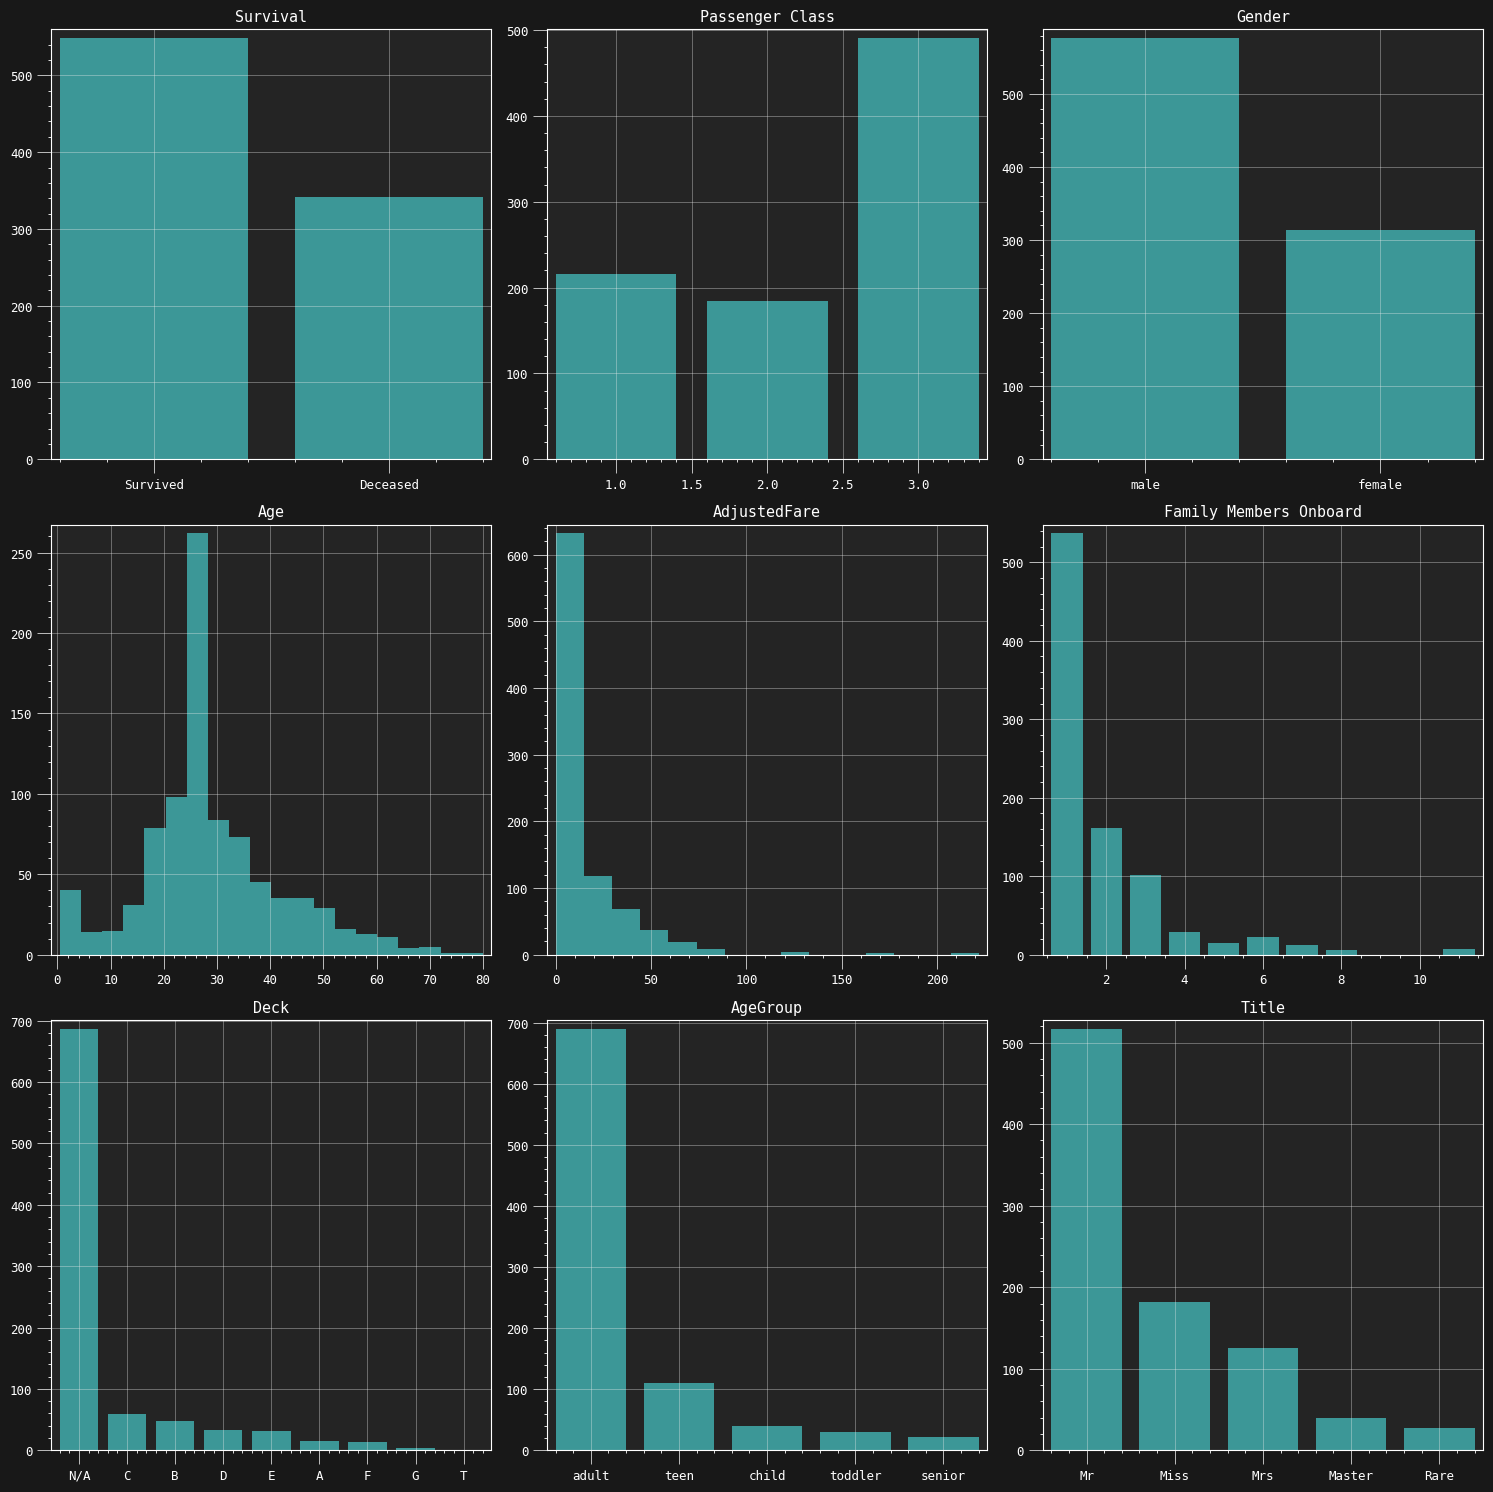

In [374]:
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]) = plt.subplots(3, 3, figsize=(15, 15))

survived = pd.DataFrame(df["Survived"].value_counts())
ax1.bar(["Survived", "Deceased"], survived['count'].values, label="Survived")
ax1.set_title("Survival", loc="center")

pclass = pd.DataFrame(df["Pclass"].value_counts())
ax2.bar(pclass.index, pclass['count'].values, label="Passenger Class")
ax2.set_title("Passenger Class", loc="center")

gender = pd.DataFrame(df["Sex"].value_counts())
ax3.bar(gender.index, gender['count'].values, label="Gender")
ax3.set_title("Gender", loc="center")

ax4.hist(df['Age'], bins=20, label="Age")
ax4.set_title("Age", loc="center")

ax5.hist(df['AdjustedFare'], bins=15, label="AdjustedFare")
ax5.set_title("AdjustedFare", loc="center")

family = pd.DataFrame(df["FamilySize"].value_counts())
ax6.bar(family.index, family['count'].values, label="Family")
ax6.set_title("Family Members Onboard", loc="center")

deck = pd.DataFrame(df["Deck"].value_counts())
ax7.bar(deck.index, deck['count'].values, label="Deck")
ax7.set_title("Deck", loc="center")

age_group = pd.DataFrame(df["AgeGroup"].value_counts())
ax8.bar(age_group.index, age_group['count'].values, label="AgeGroup")
ax8.set_title("AgeGroup", loc="center")

title = pd.DataFrame(df["Title"].value_counts())
ax9.bar(title.index, title['count'].values, label="Title")
ax9.set_title("Title", loc="center")

fig.tight_layout();
plt.show(fig)

In [375]:
q25, q50, q75 = list(df['AdjustedFare'].quantile([.25, .5, .75]))
print(f"25% Quantile: {q25}")
print(f"50% Quantile: {q50}")
print(f"75% Quantile: {q75}")

fare_bins = [0, q25, q50, q75, df['AdjustedFare'].max()]
fare_labels = ["VeryLow", "Low", "Medium", "High"]
df["Wealth"] = pd.cut(df["AdjustedFare"], bins=fare_bins, labels=fare_labels)
df.head()

25% Quantile: 7.7625
50% Quantile: 8.85
75% Quantile: 24.2882


,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title,HasCabin,IsAlone,IsTitleRare,Wealth
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr,0,0,0,VeryLow
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs,1,0,0,High
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss,0,1,0,Low
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs,1,0,0,High
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr,0,1,0,Low


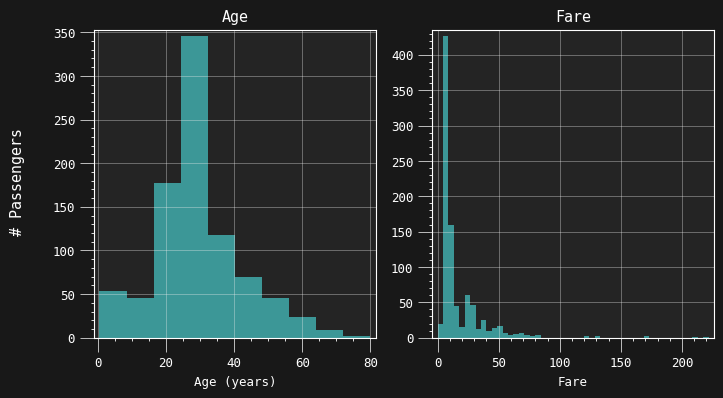

In [376]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8,4))
ax1.hist(df['Age'], bins=10)
ax1.set_xlabel('Age (years)')
ax1.set_title('Age')
ax2.hist(df['AdjustedFare'], bins=50)
ax2.set_xlabel('Fare')
ax2.set_title('Fare')
fig.supylabel('# Passengers')
plt.show(fig)

There are 15 AdjustedFare values equal to zero, replaced with median.


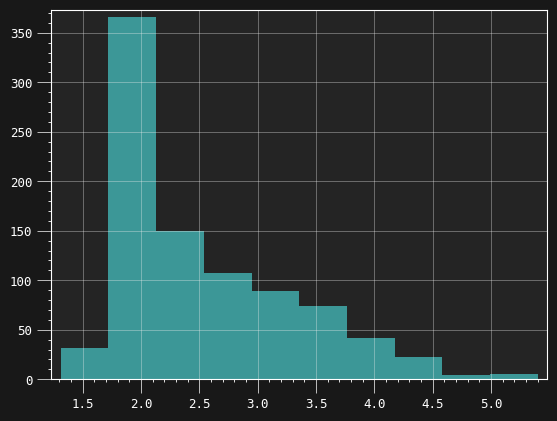

In [377]:
print(f"There are {df[df['AdjustedFare'] == 0].count()['Survived']} AdjustedFare values equal to zero, replaced with median.")
df['AdjustedFare'].replace(0, df['AdjustedFare'].median(), inplace=True)
df['LogFare'] = np.log(df['AdjustedFare'])
plt.show(df['LogFare'].hist())

In [378]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,AdjustedFare,FamilySize,Deck,AgeGroup,Title,HasCabin,IsAlone,IsTitleRare,Wealth,LogFare
0,1,0,3,male,22.0,Southampton,7.2500,2,N/A,adult,Mr,0,0,0,VeryLow,1.981001
1,2,1,1,female,38.0,Cherbourg,71.2833,2,C,adult,Mrs,1,0,0,High,4.266662
2,3,1,3,female,26.0,Southampton,7.9250,1,N/A,adult,Miss,0,1,0,Low,2.070022
3,4,1,1,female,35.0,Southampton,26.5500,2,C,adult,Mrs,1,0,0,High,3.279030
4,5,0,3,male,35.0,Southampton,8.0500,1,N/A,adult,Mr,0,1,0,Low,2.085672
